In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from IPython.display import display, HTML

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load the dataset for recommenders

In [2]:
data_path = os.path.join("data", "hotel_data")

interactions_data = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear',
             'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_data.loc[:, 'term'] = pd.Categorical(
    interactions_data['term'], categories=column_values_dict['term'])
interactions_data.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_data['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_data.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_data['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_data.loc[:, 'room_segment'] = pd.Categorical(
    interactions_data['room_segment'], categories=column_values_dict['room_segment'])
interactions_data.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_data['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_data.loc[:, 'weekend_stay'] = interactions_data['weekend_stay'].astype('str')
interactions_data.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_data['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_data.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br>
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [3]:
class CustomModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, hidden_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc = nn.ModuleList()
        self.fc.append(nn.Linear(embedding_dim, hidden_dim, bias=False))
        while hidden_dim != 4:
            self.fc.append(nn.Linear(hidden_dim, int(hidden_dim / 2), bias=False))
            hidden_dim = int(hidden_dim / 2)
        self.fc_end = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        x = user_embedding * item_embedding
        for fc in self.fc:
            x = torch.relu(fc(x))
        x = self.fc_end(x)
        x = torch.sigmoid(x)

        return x

In [4]:
from collections import deque
from recommenders.recommender import Recommender


class NNRecommender(Recommender):

    def __init__(self,
                 plot: bool = True,
                 n_epochs: int = 10,
                 n_neg_per_pos: int = 5,
                 embedding_dim: int = 8,
                 hidden_dim: int = 16,
                 lr: float = 0.01,
                 weight_decay: float = 0.001,
                 batch_size: int = 32,
                 seed: int = 6789
                 ):
        super().__init__()

        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.item_id_mapping = None
        self.user_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_reverse_mapping = None
        self.most_popular_items = None

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.validation_set_size = 0.2
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        torch.manual_seed(seed)
        self.nn_model = None

        self.plot = plot
        self.n_epochs = n_epochs
        self.n_neg_per_pos = n_neg_per_pos
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.weight_decay = weight_decay
        self.batch_size = batch_size

    def map_ids(self, df: pd.DataFrame) -> pd.DataFrame:
        unique_item_ids = df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))

        for key in self.user_id_mapping:
            self.user_id_mapping[key] += 1

        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))
        df = df.replace({
            "item_id": self.item_id_mapping,
            "user_id": self.user_id_mapping
        })
        return df

    def generate_negative_interactions(self, n_neg_per_pos: int, df: pd.DataFrame) -> (pd.DataFrame, int, int):
        negative_interactions = []

        n_users = np.max(df['user_id']) + 1
        n_items = np.max(df['item_id']) + 1

        copy = df.copy()
        copy['val'] = 1
        interactions_dict = copy.set_index(['user_id', 'item_id']).val.to_dict()

        i = 0
        temp = n_neg_per_pos * len(df)
        while i < temp:
            sample_size = 1000
            user_ids = self.rng.choice(np.arange(n_users), size=sample_size)
            item_ids = self.rng.choice(np.arange(n_items), size=sample_size)

            j = 0
            while j < sample_size and i < temp:
                if (user_ids[j], item_ids[j]) not in interactions_dict:
                    negative_interactions.append([user_ids[j], item_ids[j], 0])
                    i += 1
                j += 1

        df = pd.concat([df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        df = df.reset_index(drop=True)

        return df, n_users, n_items

    def fit(self, interactions_df: pd.DataFrame, users, items):

        interactions_df = interactions_df.copy()
        interactions_df = self.map_ids(interactions_df)

        interactions_df = interactions_df.loc[:, ['user_id', 'item_id']]
        interactions_df.loc[:, 'interacted'] = 1

        interactions_df, n_users, n_items = self.generate_negative_interactions(self.n_neg_per_pos,
                                                                                interactions_df)
        self.nn_model = CustomModel(
            n_items=n_items,
            n_users=n_users,
            embedding_dim=self.embedding_dim,
            hidden_dim=self.hidden_dim,
            seed=self.seed
        )

        loss_plot = PlotLosses()

        self.nn_model.train()
        torch_loss = torch.nn.MSELoss()
        self.nn_model.to(self.device)
        optimizer = optim.Adam(self.nn_model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        interaction_ids = self.rng.permutation(len(interactions_df))

        for epoch in range(self.n_epochs):
            logs = {}
            training_total_loss = 0.0

            n_batches = int(np.ceil(len(interaction_ids) / self.batch_size))

            for batch_idx in range(n_batches):
                batch_ids = interaction_ids[(batch_idx * self.batch_size):((batch_idx + 1) * self.batch_size)]
                batch = interactions_df.loc[batch_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)
                y = self.nn_model(batch_input).clip(0.000001, 0.999999)
                loss = torch_loss(y, y_target)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                training_total_loss += loss.item()
            training_last_avg_loss = training_total_loss / len(interaction_ids)

            logs['loss'] = training_last_avg_loss
            if self.plot:
                loss_plot.update(logs)
                loss_plot.send()

        offers_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index

    def recommend(self, users_df, items_df, n_recommendations=1):
        self.recommender_df = self.recommender_df[:0]

        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df['item_id'] = items_df['item_id'].map(self.item_id_mapping)

        for idx, user in users_df.iterrows():
            recommendations = []

            user_id = user['user_id']

            if user_id not in self.user_id_mapping:
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )
            else:
                mapped_user_id = self.user_id_mapping[user_id]

                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0] * len(ids_list))
                for k in range(len(ids_list)):
                    id_to_pos[ids_list[k]] = k

                net_input = torch.tensor(list(zip([mapped_user_id] * len(ids_list), ids_list))).to(self.device)
                scores = self.nn_model(net_input).flatten().detach().cpu().numpy()
                chosen_pos = np.argsort(-scores)[:n_recommendations]

                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id] - 1,
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )

            user_recommendations = pd.DataFrame(recommendations)
            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df


# Quick test of the recommender

In [5]:
items = interactions_data.loc[:, ['item_id'] + base_item_features].drop_duplicates()

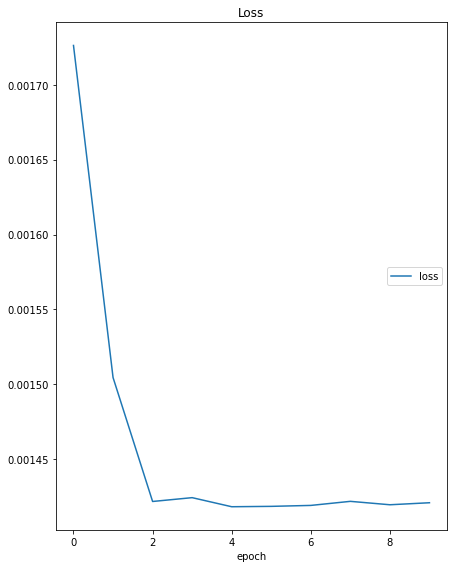

Loss
	loss             	 (min:    0.001, max:    0.002, cur:    0.001)


In [6]:
mlp_recommender = NNRecommender(**{
    'n_neg_per_pos': 10,
    'lr': 0.01,
    'weight_decay': 0.001,
    'batch_size': 64,
    'n_epochs': 10,
    'embedding_dim': 8,
    'hidden_dim': 64
})
mlp_recommender.fit(interactions_data, None, None)

In [7]:
# Recommender method
recommendations = mlp_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items, 10)

recommendations = pd.merge(recommendations, items, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,14,0.493031,OffSeason,[4-7],Standard,[160-260],[3-4],True
1,1,207,0.481662,HighSeason,[2-3],Standard,[160-260],[5-inf],True
2,1,114,0.481546,WinterVacation,[2-3],Standard,[160-260],[1-1],False
3,1,155,0.477014,OffSeason,[2-3],Nonref,[160-260],[1-1],False
4,1,21,0.476840,OffSeason,[2-3],Standard,[160-260],[2-2],False
5,1,683,0.470245,NewYear,[0-1],Standard,[160-260],[2-2],False
6,1,9,0.467938,HighSeason,[2-3],Standard,[160-260],[3-4],True
7,1,22,0.453007,OffSeason,[2-3],Standard,[160-260],[3-4],True
8,1,57,0.450120,OffSeason,[2-3],Nonref,[160-260],[3-4],False
9,1,55,0.443553,OffSeason,[2-3],Nonref,[160-260],[2-2],True


# Tuning method

In [8]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [9]:
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll import scope
import traceback


def tune_recommender(recommender_class, interactions_df, items_df,
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest,
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1

    if not succeded:
        return None

    # Validate

    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results,
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5',
                                    'NDCG@10'])

    display(HTML(results.to_html()))

    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

In [119]:
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'batch_size': scope.int(hp.quniform('batch_size', 32, 64, 16)),
    'lr': 0.001,
    'weight_decay': 0.0001,
    'n_epochs': 15,
    'embedding_dim': 8,
    'hidden_dim': 16,
    'plot': False
}

best_param_set = tune_recommender(NNRecommender, interactions_data, items,
                                  param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

100%|██████████| 10/10 [17:54<00:00, 107.41s/trial, best loss: -0.22132881929750317]


TypeError: slice indices must be integers or None or have an __index__ method

# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

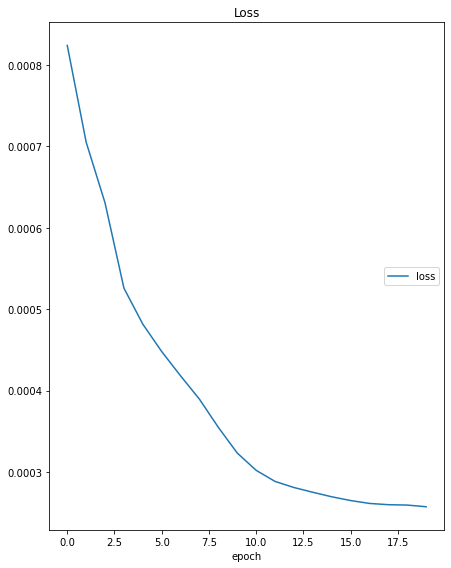

Loss
	loss             	 (min:    0.000, max:    0.001, cur:    0.000)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMF_Recommender,0.043788,0.118126,0.160217,0.219959,0.043788,0.086246,0.103823,0.122762


In [10]:
gmf_recommender = NNRecommender(**{
    'n_neg_per_pos': 10,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'batch_size': 128,
    'n_epochs': 20,
    'embedding_dim': 8,
    'hidden_dim': 16
})

gmf_tts_results = [['GMF_Recommender'] + list(evaluate_train_test_split_implicit(
    gmf_recommender, interactions_data, items))]

gmf_tts_results = pd.DataFrame(
    gmf_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_tts_results.to_html()))

In [111]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_data, items))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results,
    columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.044128,0.118805,0.160557,0.223693,0.044128,0.086755,0.104216,0.124468


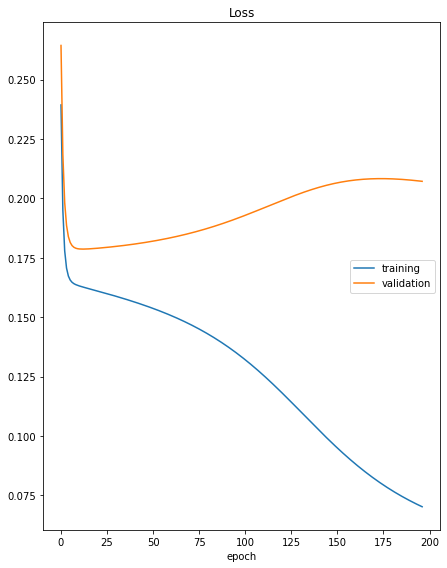

Loss
	training         	 (min:    0.070, max:    0.239, cur:    0.070)
	validation       	 (min:    0.179, max:    0.264, cur:    0.207)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.045146,0.12186,0.164291,0.229124,0.045146,0.088881,0.106604,0.127288


In [112]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=200, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_data, items))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results,
    columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))